In [ ]:
# %cd /content/drive/MyDrive/IT STEP University/uav-nav/
# !pip install earthengine-api

https://developers.google.com/earth-engine/guides/auth

In [ ]:
import ee
import folium

ee.Authenticate()

ee.Initialize(project='ee-povstenko')

region = ee.Geometry.Rectangle([24.148007, 49.80144, 24.149381, 49.80234])

region_coords = [24.1580833, 49.8014167]
region = ee.Geometry.Point(region_coords).buffer(1000)

sentinel = ee.ImageCollection("COPERNICUS/S2_HARMONIZED") \
    .filterDate("2024-01-01", "2024-12-31") \
    .filterBounds(region) \
    .sort("CLOUDY_PIXEL_PERCENTAGE", True) \
    .first()

# sentinel = sentinel.clip(region)

rgb = sentinel.visualize(
    bands=['B4', 'B3', 'B2'],
    min=0,
    max=3000
)

map = folium.Map(location=[region_coords[1], region_coords[0]], zoom_start=15)
map_id_dict = ee.Image(rgb).getMapId()
folium.TileLayer(
    tiles=map_id_dict['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    overlay=True,
    name='Sentinel-2 RGB'
).add_to(map)


folium.LayerControl().add_to(map)

map

In [1]:
!pip install rasterio
!pip install matplotlib
!pip install splitraster
!pip install GDAl
!pip install tensorflow
!pip install imgaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 12.2 MB/s eta 0:00:00


In [11]:
import rasterio
from osgeo import gdal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from splitraster import geo
import os
import pandas as pd
import cv2

tiff_path = "sample.tif"
output_dir = "tiles"

# Data Preparation



## Split image to Tiles


### Split to tiles using Splitraser

In [3]:
crop_size = 256
repetition_rate = 0.5
overwrite = True

n = geo.split_image(tiff_path, output_dir, crop_size, repetition_rate=repetition_rate, overwrite=overwrite)

Input Image File Shape (D, H, W):(3, 601, 601)
crop_size=256, stride=128
Padding Image File Shape (D, H, W):(3, 640, 640)


Generating: 100%|██████████| 16/16 [00:00<00:00, 143.92img/s]


In [ ]:
# create zip
#!zip -r tiles_splitracer.zip tiles/
%rm -r tiles/*

### Split to tiles using GDAL

In [4]:
ds = gdal.Open(tiff_path)
gt = ds.GetGeoTransform()
print(gt)

pr = ds.GetProjection()
print(pr)

#get coordinates of upper left corner
xmin = gt[0]
ymax = gt[3]
res = gt[1]

#determine total length of raster
xlen = res * ds.RasterXSize
ylen = res * ds.RasterYSize

#number of tiles in x and y direction
xdiv = 5
ydiv = 5

#size of a single tile
xsize = xlen/xdiv
ysize = ylen/ydiv

#create lists of x and y coordinates
xsteps = [xmin + xsize * i for i in range(xdiv+1)]
ysteps = [ymax - ysize * i for i in range(ydiv+1)]

# init dataframe with class data
# Class is the folder name (tile{i}{j})
df_classes = pd.DataFrame(columns=['i', 'j', 'class_label', 'folder', 'tiff_file', 'xmin', 'xmax', 'ymin', 'ymax'])

#loop over min and max x and y coordinates
for i in range(xdiv):
    for j in range(ydiv):
        xmin = xsteps[i]
        xmax = xsteps[i+1]
        ymax = ysteps[j]
        ymin = ysteps[j+1]

        folder_path = "tiles/tile"+str(i)+str(j)+'/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        tiff_file_path = folder_path+str(i)+str(j)+".tif"

        df_classes = pd.concat([pd.DataFrame([[i, j, 'tile'+str(i)+str(j), folder_path, tiff_file_path, xmin, xmax, ymin, ymax]], columns=df_classes.columns), df_classes], ignore_index=True)

        gdal.Warp(folder_path+str(i)+str(j)+".tif", ds,
                  outputBounds = (xmin, ymin, xmax, ymax), dstNodata = -9999)

df_classes.style

(594524.0, 10.0, 0.0, 5786626.0, 0.0, -10.0)
PROJCS["WGS 84 / UTM zone 31N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32631"]]


<ipython-input-4-8204e3c8a410>:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_classes = pd.concat([pd.DataFrame([[i, j, 'tile'+str(i)+str(j), folder_path, tiff_file_path, xmin, xmax, ymin, ymax]], columns=df_classes.columns), df_classes], ignore_index=True)


,i,j,class_label,folder,tiff_file,xmin,xmax,ymin,ymax
0,4,4,tile44,tiles/tile44/,tiles/tile44/44.tif,599332.000000,600534.000000,5780616.000000,5781818.000000
1,4,3,tile43,tiles/tile43/,tiles/tile43/43.tif,599332.000000,600534.000000,5781818.000000,5783020.000000
2,4,2,tile42,tiles/tile42/,tiles/tile42/42.tif,599332.000000,600534.000000,5783020.000000,5784222.000000
3,4,1,tile41,tiles/tile41/,tiles/tile41/41.tif,599332.000000,600534.000000,5784222.000000,5785424.000000
4,4,0,tile40,tiles/tile40/,tiles/tile40/40.tif,599332.000000,600534.000000,5785424.000000,5786626.000000
5,3,4,tile34,tiles/tile34/,tiles/tile34/34.tif,598130.000000,599332.000000,5780616.000000,5781818.000000
6,3,3,tile33,tiles/tile33/,tiles/tile33/33.tif,598130.000000,599332.000000,5781818.000000,5783020.000000
7,3,2,tile32,tiles/tile32/,tiles/tile32/32.tif,598130.000000,599332.000000,5783020.000000,5784222.000000
8,3,1,tile31,tiles/tile31/,tiles/tile31/31.tif,598130.000000,599332.000000,5784222.000000,5785424.000000
9,3,0,tile30,tiles/tile30/,tiles/tile30/30.tif,598130.000000,599332.000000,5785424.000000,5786626.000000


In [ ]:
# create zip
!zip -r tiles_gdal.zip tiles/

updating: tiles/ (stored 0%)
  adding: tiles/tile34/ (stored 0%)
  adding: tiles/tile34/34_21.png (deflated 0%)
  adding: tiles/tile34/34_17.png (deflated 0%)
  adding: tiles/tile34/34_29.png (deflated 1%)
  adding: tiles/tile34/34_2.png (stored 0%)
  adding: tiles/tile34/34_48.png (deflated 0%)
  adding: tiles/tile34/34_31.png (deflated 3%)
  adding: tiles/tile34/34_18.png (deflated 0%)
  adding: tiles/tile34/34_22.png (stored 0%)
  adding: tiles/tile34/34_46.png (deflated 0%)
  adding: tiles/tile34/34_35.png (deflated 0%)
  adding: tiles/tile34/34_41.png (deflated 0%)
  adding: tiles/tile34/34_0.png (deflated 0%)
  adding: tiles/tile34/34_39.png (deflated 0%)
  adding: tiles/tile34/34_40.png (stored 0%)
  adding: tiles/tile34/34_6.png (stored 0%)
  adding: tiles/tile34/34_16.png (deflated 0%)
  adding: tiles/tile34/34_20.png (deflated 1%)
  adding: tiles/tile34/34_15.png (stored 0%)
  adding: tiles/tile34/34_19.png (deflated 0%)
  adding: tiles/tile34/34_3.png (deflated 0%)
  adding:

 Preview of tiles:

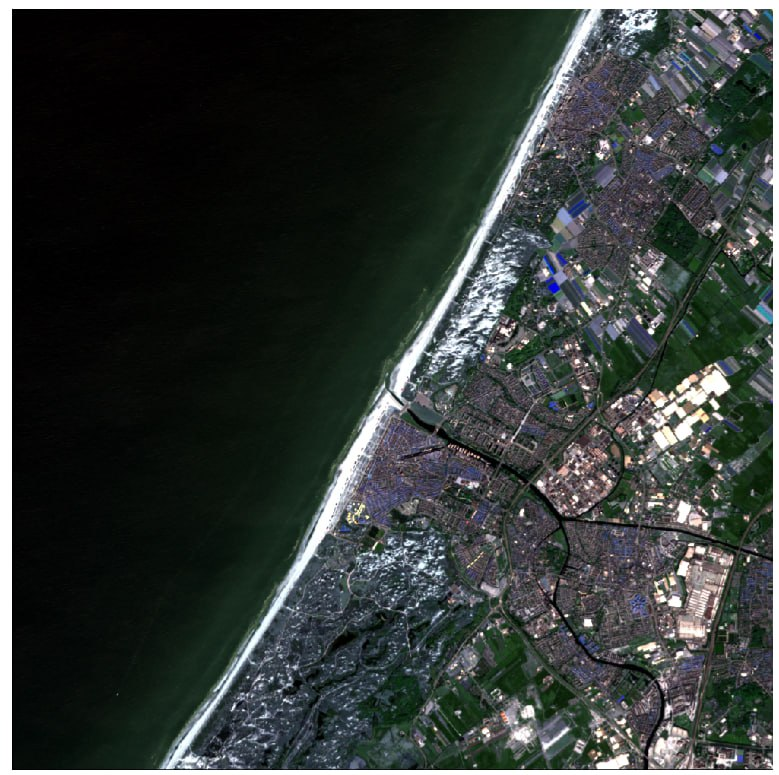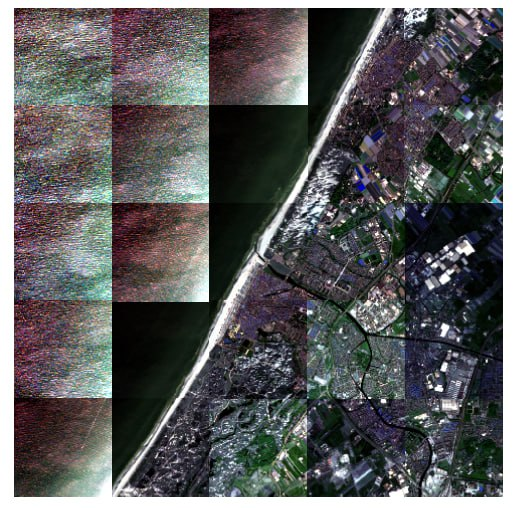

## Visualizing GeoTiff images


### Displaying one band

3


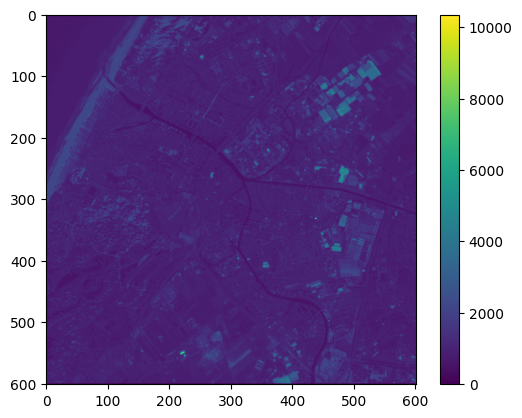

In [5]:
print(ds.RasterCount)

red_band = ds.GetRasterBand(1).ReadAsArray()
green_band = ds.GetRasterBand(3).ReadAsArray()
blue_band = ds.GetRasterBand(2).ReadAsArray()
rgb = np.dstack((red_band,
                 green_band,
                 blue_band))

plt.imshow(blue_band)
plt.colorbar()
plt.show()

### Bitmask

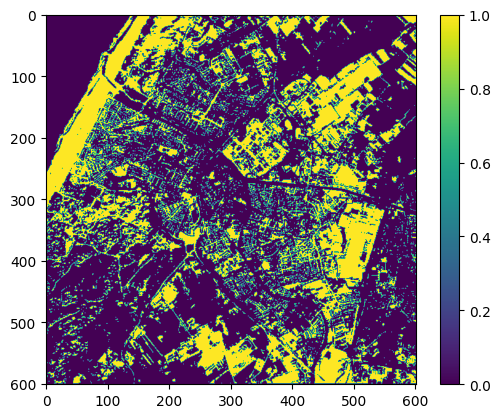

In [6]:
binmask = np.where((blue_band >= np.mean(blue_band)), 1, 0)

plt.figure()
plt.imshow(binmask)
plt.colorbar()
plt.show()

### Minimum and Maximum normalization

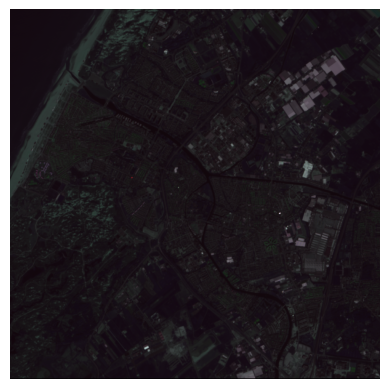

In [7]:
def scale_min_max(array):
    return (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))

rgb_min_max_normalized = np.dstack((scale_min_max(red_band),
                            scale_min_max(green_band),
                            scale_min_max(blue_band)))

plt.imshow(rgb_min_max_normalized)
plt.axis('off')
plt.show()

### Standard Deviation scale

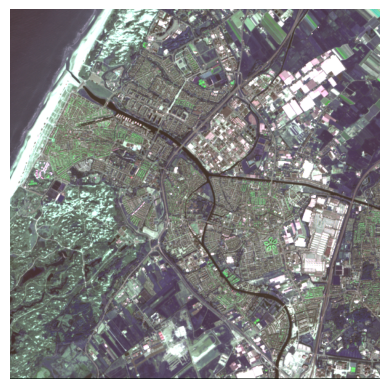

In [8]:
def scale_Std(array):
    return((array - (np.nanmean(array)-np.nanstd(array)*2))/((np.nanmean(array)+np.nanstd(array)*2) - (np.nanmean(array)-np.nanstd(array)*2)))

rgb_std_normalized = np.dstack((scale_Std(red_band),
                            scale_Std(green_band),
                            scale_Std(blue_band)))

plt.imshow(rgb_std_normalized)
plt.axis('off')
plt.show()

### Cumulative Count Cut Normalization

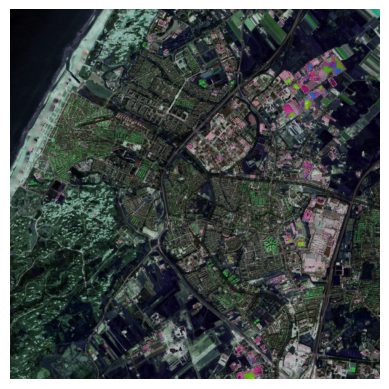

In [12]:
def scale_CCC(array):
    return (array - np.nanpercentile(array,2)) / (np.nanpercentile(array,98) - np.nanpercentile(array,2))

def get_rgb_tiff(ds, inpaint_treshold=200):
    red_band = ds.GetRasterBand(1).ReadAsArray()
    green_band = ds.GetRasterBand(3).ReadAsArray()
    blue_band = ds.GetRasterBand(2).ReadAsArray()

    arr = np.dstack((scale_CCC(red_band),
                            scale_CCC(green_band),
                            scale_CCC(blue_band)))
    arr = (arr*255).astype('uint8')

    # Create a mask where any channel exceeds the threshold
    mask = (arr[:, :, 0] > inpaint_treshold) | (arr[:, :, 1] > inpaint_treshold) | (arr[:, :, 2] > inpaint_treshold)

    # Convert mask to uint8 format for OpenCV (0 or 255)
    mask_uint8 = mask.astype(np.uint8) * 255

    # Apply inpainting using the Telea method
    arr = cv2.inpaint(arr, mask_uint8, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return arr

plt.imshow(get_rgb_tiff(ds))
plt.axis('off')
plt.show()

## Check of file splitting

Merge all tiles into one GeoTiff plot and check if all tiles are well positioned

In [13]:
import glob
file_list = glob.glob('tiles/tile[0-9][0-9]/[0-9][0-9].tif')
file_list

['tiles/tile00/00.tif',
 'tiles/tile33/33.tif',
 'tiles/tile12/12.tif',
 'tiles/tile41/41.tif',
 'tiles/tile40/40.tif',
 'tiles/tile11/11.tif',
 'tiles/tile04/04.tif',
 'tiles/tile34/34.tif',
 'tiles/tile14/14.tif',
 'tiles/tile31/31.tif',
 'tiles/tile20/20.tif',
 'tiles/tile42/42.tif',
 'tiles/tile13/13.tif',
 'tiles/tile23/23.tif',
 'tiles/tile32/32.tif',
 'tiles/tile30/30.tif',
 'tiles/tile02/02.tif',
 'tiles/tile44/44.tif',
 'tiles/tile01/01.tif',
 'tiles/tile10/10.tif',
 'tiles/tile43/43.tif',
 'tiles/tile21/21.tif',
 'tiles/tile24/24.tif',
 'tiles/tile03/03.tif',
 'tiles/tile22/22.tif']

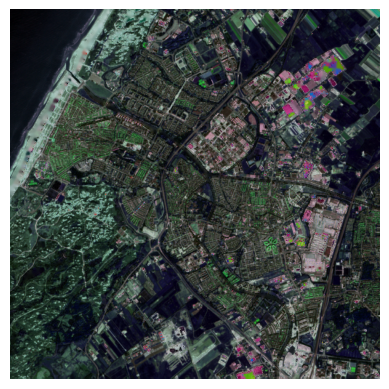

In [14]:
vrt = gdal.BuildVRT('merged.vrt', file_list)
gdal.Translate('merged.tif', vrt, xRes= 10, yRes= -10)
vrt = None # close dataset

ds = gdal.Open('merged.tif') # load new file

plt.imshow(get_rgb_tiff(ds))
plt.axis('off')
plt.show()

## Data Augmentation

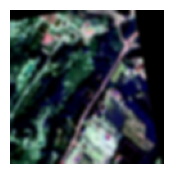

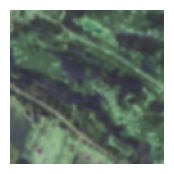

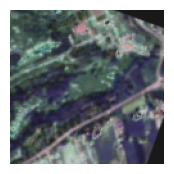

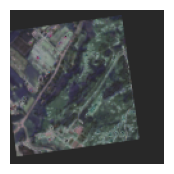

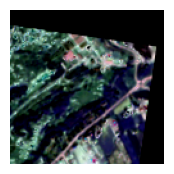

In [16]:
import imgaug.augmenters as iaa
import cv2

augmentation = iaa.Sequential([
    # flip
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),

    # rotate + scale
    iaa.Affine(
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-30, 30),
        scale=(0.8, 1.5),
        shear=(-8, 8)
    ),

    # multiply
    iaa.Multiply((0.8, 1.2), per_channel=0.2),

    # contrast
    iaa.LinearContrast((0.5, 1.5)),

    # blur
    iaa.Sometimes(0.5, iaa.GaussianBlur((0.0, 1.5)))
])



# preview of augmented data

# open tif
ds = gdal.Open('tiles/tile13/13.tif')
arr = get_rgb_tiff(ds)
# save as png
cv2.imwrite('tiles/tile13/13.png', arr)

img = cv2.imread('tiles/tile13/13.png')

# preview
for i in range(5):
    augmented = augmentation(images = [img])
    for aug in augmented:
        plt.figure(figsize=(2,2))
        plt.imshow(aug)
        plt.axis('off')
        plt.show()

In [ ]:
# for each class generate augmented data
for index, row in df_classes.iterrows():
    # open tif
    ds = gdal.Open(row['tiff_file'])
    arr = get_rgb_tiff(ds)

    # save as png
    cv2.imwrite(row['folder']+str(row['i'])+str(row['j'])+'.png', arr)

    # add 49 augmented images per class
    for i in range(99):
        augmented = augmentation(images = [arr])
        for aug in augmented:
            aug_file_path = row['folder']+str(row['i'])+str(row['j'])+'_'+str(i)+'.png'

            cv2.imwrite(aug_file_path, aug)

            print(aug_file_path)
            # plt.figure(figsize=(1,1))
            # plt.imshow(aug)
            # plt.axis('off')
            # plt.show()

    # close file
    ds = None

# Dataset split

In [29]:
from sklearn.model_selection import train_test_split

df_classes.head()
# # Split into training and testing sets
# train_df, test_df = train_test_split(df_classes, test_size=0.2, stratify=df_classes["class_label"], random_state=42)

,i,j,class_label,folder,tiff_file,xmin,xmax,ymin,ymax
0,4,4,tile44,tiles/tile44/,tiles/tile44/44.tif,599332.0,600534.0,5780616.0,5781818.0
1,4,3,tile43,tiles/tile43/,tiles/tile43/43.tif,599332.0,600534.0,5781818.0,5783020.0
2,4,2,tile42,tiles/tile42/,tiles/tile42/42.tif,599332.0,600534.0,5783020.0,5784222.0
3,4,1,tile41,tiles/tile41/,tiles/tile41/41.tif,599332.0,600534.0,5784222.0,5785424.0
4,4,0,tile40,tiles/tile40/,tiles/tile40/40.tif,599332.0,600534.0,5785424.0,5786626.0


In [30]:
data = []

# loop the directory and collect file paths with labels
for root, dirs, files in os.walk(output_dir+'/'):
    for file in files:
        if file.endswith(".png"):  # Only consider PNG images
            class_label = os.path.basename(root)  # Class is the folder name (tile{i}{j})
            file_path = os.path.join(root, file)
            data.append((file_path, class_label))

# Convert to a dataframe
df = pd.DataFrame(data, columns=["image_path", "class_label"])
df.head()

,image_path,class_label
0,tiles/tile00/00_11.png,tile00
1,tiles/tile00/00_88.png,tile00
2,tiles/tile00/00_28.png,tile00
3,tiles/tile00/00_14.png,tile00
4,tiles/tile00/00_22.png,tile00


In [31]:
df_merged = df.merge(df_classes, on='class_label', how='left')
df_merged.head()

,image_path,class_label,i,j,folder,tiff_file,xmin,xmax,ymin,ymax
0,tiles/tile00/00_11.png,tile00,0,0,tiles/tile00/,tiles/tile00/00.tif,594524.0,595726.0,5785424.0,5786626.0
1,tiles/tile00/00_88.png,tile00,0,0,tiles/tile00/,tiles/tile00/00.tif,594524.0,595726.0,5785424.0,5786626.0
2,tiles/tile00/00_28.png,tile00,0,0,tiles/tile00/,tiles/tile00/00.tif,594524.0,595726.0,5785424.0,5786626.0
3,tiles/tile00/00_14.png,tile00,0,0,tiles/tile00/,tiles/tile00/00.tif,594524.0,595726.0,5785424.0,5786626.0
4,tiles/tile00/00_22.png,tile00,0,0,tiles/tile00/,tiles/tile00/00.tif,594524.0,595726.0,5785424.0,5786626.0


In [32]:
# Split into training and testing sets
train_df, test_df = train_test_split(df_merged, test_size=0.2, stratify=df_merged["class_label"], random_state=42)

train_df.describe()

,xmin,xmax,ymin,ymax
count,2000.000000,2000.000000,2.000000e+03,2.000000e+03
mean,596928.000000,598130.000000,5.783020e+06,5.784222e+06
std,1700.309833,1700.309833,1.700310e+03,1.700310e+03
min,594524.000000,595726.000000,5.780616e+06,5.781818e+06
25%,595726.000000,596928.000000,5.781818e+06,5.783020e+06
50%,596928.000000,598130.000000,5.783020e+06,5.784222e+06
75%,598130.000000,599332.000000,5.784222e+06,5.785424e+06
max,599332.000000,600534.000000,5.785424e+06,5.786626e+06


In [33]:
test_df.describe()

,xmin,xmax,ymin,ymax
count,500.000000,500.000000,5.000000e+02,5.000000e+02
mean,596928.000000,598130.000000,5.783020e+06,5.784222e+06
std,1701.587141,1701.587141,1.701587e+03,1.701587e+03
min,594524.000000,595726.000000,5.780616e+06,5.781818e+06
25%,595726.000000,596928.000000,5.781818e+06,5.783020e+06
50%,596928.000000,598130.000000,5.783020e+06,5.784222e+06
75%,598130.000000,599332.000000,5.784222e+06,5.785424e+06
max,599332.000000,600534.000000,5.785424e+06,5.786626e+06


## Pre-process image train test dataset

In [34]:
def preprocess_image(image_path, target_size=(128, 128)):
    img = cv2.imread(image_path)
    # Resize the image
    img = cv2.resize(img, target_size)
    # Normalize pixel values to [0, 1]
    img = img / 255.0
    return img

# Apply preprocessing to train and test sets
train_images = np.array([preprocess_image(path) for path in train_df["image_path"]])
test_images = np.array([preprocess_image(path) for path in test_df["image_path"]])

# Extract labels (class indices) for training and testing
train_labels = train_df["class_label"].factorize()[0]  # Convert class labels to indices
test_labels = test_df["class_label"].factorize()[0]

# Build Model

In [35]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [ ]:
train_labels_onehot = to_categorical(train_labels)
test_labels_onehot = to_categorical(test_labels)

# Split a portion of the training set for validation
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels_onehot, test_size=0.2, random_state=42)
# Load the ResNet50 base model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
# Add custom layers for classification
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_labels_onehot.shape[1], activation='softmax')(x)  # Number of classes
# Create the complete model
model = Model(inputs=base_model.input, outputs=output)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,  # Adjust based on your needs
    batch_size=32,  # Adjust based on memory and dataset size
    verbose=1
)
# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers
    layer.trainable = True

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,  # Fine-tuning usually requires fewer epochs
    batch_size=32,
    verbose=1
)
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels_onehot, verbose=1)
model.save('resnet50_finetuned_model.h5')

In [39]:
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 68.13%


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step


array([17,  3, 13, 15,  1,  0, 10, 10, 14, 10, 21,  3, 17,  8, 15,  7, 23,
       20, 13, 20, 16, 17,  1,  2, 22, 22, 13, 14, 20, 23, 18, 15, 13, 23,
       21, 24,  2,  6,  7, 14,  5, 19,  6, 20, 19,  5, 21, 10, 10, 14,  4,
       22, 20, 22, 22,  7,  7, 19, 23, 20, 19, 14,  5, 10,  3, 12, 13, 13,
       16,  6, 17,  3, 24, 20,  7, 14, 15, 13, 10, 18,  2, 23, 14,  6,  9,
       17, 19, 14,  7, 14, 22,  7, 20, 17, 23, 22, 13, 16, 19, 10,  7, 14,
        0, 12,  7,  4, 13, 23,  9, 24, 13, 14, 13, 13, 22,  8, 10, 23,  6,
       24, 24, 13,  1,  8,  5, 22, 22, 22, 19, 14, 17, 16, 20, 16, 11, 14,
        7, 23, 20, 10,  6,  1, 23, 21,  7, 10, 21, 18, 16,  1, 21, 23, 12,
       18, 24, 10, 18,  8, 23, 19, 22,  9,  5,  3, 15, 16,  6, 10,  5, 21,
       17,  3, 22,  1, 13, 18, 19,  8, 21, 10, 18, 14,  5,  5,  9, 24,  7,
       18,  0, 20, 18,  7,  1, 16,  4, 15, 22,  3, 17, 22, 19,  3,  5, 14,
        5, 10, 13, 19,  3, 21, 19, 24, 12, 17, 17,  0, 24, 10, 22,  6, 22,
       19,  8, 13,  3,  6